# Sentiment Analysis

## Import modules

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import nltk
import spacy
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from tokenizers import BertWordPieceTokenizer
from transformers import AutoTokenizer, TFBertModel, AutoModelForSequenceClassification
# from transformers import BertTokenizer
import transformers
import tensorflow as tf
from textblob import TextBlob
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy.special import softmax

2023-07-26 16:16:09.021724: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-26 16:16:09.137689: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 16:16:09.964058: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/saikat/miniconda3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm 

## Reading the Data

In [2]:
train_raw_data = pd.read_excel("data/bank_a_sentiment_analysis_translated_inputdata.xlsx")
test_raw_data = pd.read_excel("data/bank_a_sentiment_analysis_translated_inputdata_unseen.xlsx")

In [3]:
train_raw_data.head()

review_id                                  translated_review  \
0          1  in the branch of san marco evangelista, the em...   
1          2  5 00 of commissions to withdraw your money at ...   
2          3                     when the f24 on the app thanks   
3          4                              lower the commissions   
4          5  promotes and supports the small business in th...   

  actual_sentiment  
0         Positive  
1         Negative  
2          Neutral  
3          Neutral  
4         Positive

In [4]:
test_raw_data.head()

review_id                                  translated_review  \
0         41                           c always a little to fix   
1         44  there are multiple areas of improvement exampl...   
2         76       banca xxyyzz of valdengo to a great director   
3        111       banca xxyyzz of valdengo to a great director   
4        131  i lowered the votes given in previous evaluati...   

  actual_sentiment  
0          Neutral  
1          Neutral  
2         Positive  
3         Negative  
4         Negative

In [5]:
print(train_raw_data.shape)
print(test_raw_data.shape)

(3486, 3)
(200, 3)


In [6]:
train_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   review_id          3486 non-null   int64 
 1   translated_review  3481 non-null   object
 2   actual_sentiment   3482 non-null   object
dtypes: int64(1), object(2)
memory usage: 81.8+ KB


We have 5 null value in translated_review column and 4 null value in actual_sentiment column

In [7]:
test_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   review_id          200 non-null    int64 
 1   translated_review  200 non-null    object
 2   actual_sentiment   200 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


### Remove Blank Records

In [8]:
# replace all blank values with nan
train_raw_data = train_raw_data.replace(r'^s*$', float('NaN'), regex = True)


In [9]:
train_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   review_id          3486 non-null   int64 
 1   translated_review  3481 non-null   object
 2   actual_sentiment   3482 non-null   object
dtypes: int64(1), object(2)
memory usage: 81.8+ KB


In [10]:
train_raw_data.dropna(how="any", inplace=True)

In [11]:
test_raw_data = test_raw_data.replace(r'^s*$', float('NaN'), regex = True)


In [12]:
test_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   review_id          200 non-null    int64 
 1   translated_review  200 non-null    object
 2   actual_sentiment   200 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


In [13]:
test_raw_data.dropna(subset=["translated_review"], inplace=True)

There are no null Values in the test set

## EDA

In [14]:
train_raw_data.head()

review_id                                  translated_review  \
0          1  in the branch of san marco evangelista, the em...   
1          2  5 00 of commissions to withdraw your money at ...   
2          3                     when the f24 on the app thanks   
3          4                              lower the commissions   
4          5  promotes and supports the small business in th...   

  actual_sentiment  
0         Positive  
1         Negative  
2          Neutral  
3          Neutral  
4         Positive

In [15]:
train_raw_data.describe(include=[object])

translated_review actual_sentiment
count                3477             3477
unique               3305                3
top     because i am fine         Positive
freq                   11             1831

In [16]:
test_raw_data.describe(include=[object])

translated_review actual_sentiment
count                                            200              200
unique                                           198                3
top     banca xxyyzz of valdengo to a great director         Positive
freq                                               2              106

### Average word count per type of review

In [17]:
def func_word_len(x):
    return len(str(x).split())
temp = train_raw_data.copy(deep=True)
temp['word_count']=temp['translated_review'].apply(func_word_len)

In [18]:
temp.groupby("actual_sentiment")["word_count"].mean().reset_index()

actual_sentiment  word_count
0         Negative   18.440000
1          Neutral    9.821224
2         Positive    8.648826

### Distribution of sentiment 

Lets look at the distribution of sentiment in the train set

In [19]:
temp = train_raw_data.groupby('actual_sentiment').count()['translated_review'].reset_index().sort_values(by='translated_review',ascending=False)
temp.style.background_gradient(cmap='Purples')

<Axes: xlabel='actual_sentiment', ylabel='count'>

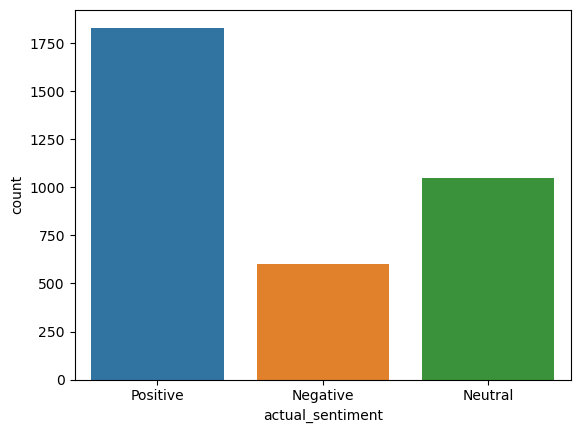

In [20]:
sns.countplot(data=train_raw_data, x="actual_sentiment")

In [21]:
fig = go.Figure(go.Funnelarea(
    text =temp["actual_sentiment"],
    values = temp["translated_review"],
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

### Words per review

Let's count words per review in train data

In [22]:
train = train_raw_data.copy(deep=True)
test = test_raw_data.copy(deep=True)

In [23]:
train['words_per_review'] = [len(x.split()) for x in train['translated_review'].tolist()]
train.head()

review_id                                  translated_review  \
0          1  in the branch of san marco evangelista, the em...   
1          2  5 00 of commissions to withdraw your money at ...   
2          3                     when the f24 on the app thanks   
3          4                              lower the commissions   
4          5  promotes and supports the small business in th...   

  actual_sentiment  words_per_review  
0         Positive                28  
1         Negative                13  
2          Neutral                 7  
3          Neutral                 3  
4         Positive                 9

Let's count words per review in test data

In [24]:
test['words_per_review'] = [len(x.split()) for x in test['translated_review'].tolist()]
test.head()

review_id                                  translated_review  \
0         41                           c always a little to fix   
1         44  there are multiple areas of improvement exampl...   
2         76       banca xxyyzz of valdengo to a great director   
3        111       banca xxyyzz of valdengo to a great director   
4        131  i lowered the votes given in previous evaluati...   

  actual_sentiment  words_per_review  
0          Neutral                 6  
1          Neutral                11  
2         Positive                 8  
3         Negative                 8  
4         Negative                36

## Clean the data

### Lemmatization

Let's do lemmatization in train data

Lemmatization using Spacy

In [25]:
nlp = spacy.load('en_core_web_sm')

In [26]:
def lemmatize_text(text):
    doc1 = nlp(text)
    return ' '.join([token.lemma_ for token in doc1])

In [27]:
train["translated_review"] = train["translated_review"].apply(lemmatize_text)

In [28]:
train.head()

review_id                                  translated_review  \
0          1  in the branch of san marco evangelista , the e...   
1          2  5 00 of commission to withdraw your money at t...   
2          3                      when the f24 on the app thank   
3          4                               lower the commission   
4          5  promote and support the small business in the ...   

  actual_sentiment  words_per_review  
0         Positive                28  
1         Negative                13  
2          Neutral                 7  
3          Neutral                 3  
4         Positive                 9

Let's do lemmatization in test data

In [29]:
test["translated_review"] = test["translated_review"].apply(lemmatize_text)

In [30]:
test.head()

review_id                                  translated_review  \
0         41                           c always a little to fix   
1         44  there be multiple area of improvement example ...   
2         76       banca xxyyzz of valdengo to a great director   
3        111       banca xxyyzz of valdengo to a great director   
4        131  I lower the vote give in previous evaluation s...   

  actual_sentiment  words_per_review  
0          Neutral                 6  
1          Neutral                11  
2         Positive                 8  
3         Negative                 8  
4         Negative                36

### Remove special characters

Remove special characters from train data

In [31]:
train['translated_review'] = train['translated_review'].replace("[^a-zA-Z0-9\s]+", "",regex=True)

Remove special characters from test data

In [32]:
test['translated_review'] = test['translated_review'].replace("[^a-zA-Z0-9\s]+", "",regex=True)

### Remove stop words

Remove stop words from train data

In [33]:
train['translated_review'] = train['translated_review'].apply(lambda words: ' '.join(word for word in words.split() if word.lower() not in nlp.Defaults.stop_words))

Remove stop words from test data

In [34]:
test['translated_review'] = test['translated_review'].apply(lambda words: ' '.join(word for word in words.split() if word.lower() not in nlp.Defaults.stop_words))

### Count number of words

In [35]:
# pd.Series([item for item in train['translated_review']])

In [36]:
# from collections import Counter
# from  itertools import chain

Word count in train data

In [37]:
word_count = pd.DataFrame(train['translated_review'].str.split(expand=True).stack().value_counts()).reset_index().rename(columns={"index": "word", 0: "count"})
word_count

word  count
0           bank    522
1        service    478
2       customer    345
3          staff    309
4           good    303
...          ...    ...
2609     villani      1
2610    bancking      1
2611  fragmented      1
2612    numerous      1
2613        2006      1

[2614 rows x 2 columns]

In [38]:
word_count[word_count["count"] == 1]

word  count
1208    invasive      1
1209       press      1
1210       equip      1
1211    andmerry      1
1212        pull      1
...          ...    ...
2609     villani      1
2610    bancking      1
2611  fragmented      1
2612    numerous      1
2613        2006      1

[1406 rows x 2 columns]

Word count in text data

In [39]:
word_count = pd.DataFrame(test['translated_review'].str.split(expand=True).stack().value_counts()).reset_index().rename(columns={"index": "word", 0: "count"})
word_count

word  count
0               bank     41
1            service     30
2          excellent     26
3           customer     21
4              staff     20
..               ...    ...
420       dynamicity      1
421  confidentiality      1
422      correctness      1
423          webBank      1
424              net      1

[425 rows x 2 columns]

In [40]:
word_count[word_count["count"] == 1]

word  count
138             size      1
139        necessary      1
140        telephone      1
141        semprogno      1
142             dear      1
..               ...    ...
420       dynamicity      1
421  confidentiality      1
422      correctness      1
423          webBank      1
424              net      1

[287 rows x 2 columns]

### Seperate blank reviews after processing

In [41]:
train = train.replace(r'^s*$', float('NaN'), regex = True)

In [42]:
train_blank_reviews = train[train["translated_review"].isna()]

In [43]:
train.dropna(subset=["translated_review"], inplace=True)

In [44]:
train_blank_reviews.shape

(23, 4)

So, we can see there are 26 blank reviews in train data after processing

In [45]:
train_blank_reviews.groupby(by=["actual_sentiment"])["review_id"].count()

actual_sentiment
Negative     2
Neutral      7
Positive    14
Name: review_id, dtype: int64

Blank reviews of train data have 15 positive reviews, 3 negative reviews and 8 nutral reviews

In [46]:
test = test.replace(r'^s*$', float('NaN'), regex = True)

In [47]:
test_blank_reviews = test[test["translated_review"].isna()]

In [48]:
test.dropna(subset=["translated_review"], inplace=True)

In [49]:
test_blank_reviews.shape

(2, 4)

So, we can see there are 2 blank reviews in test data after processing

## Insights on processed data

In [50]:
train.shape

(3454, 4)

In [51]:
test.shape

(198, 4)

In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3454 entries, 0 to 3480
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   review_id          3454 non-null   int64 
 1   translated_review  3454 non-null   object
 2   actual_sentiment   3454 non-null   object
 3   words_per_review   3454 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 134.9+ KB


In [53]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 0 to 199
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   review_id          198 non-null    int64 
 1   translated_review  198 non-null    object
 2   actual_sentiment   198 non-null    object
 3   words_per_review   198 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 7.7+ KB


In [54]:
train.describe(include=[object])

translated_review actual_sentiment
count               3454             3454
unique              3057                3
top                 find         Positive
freq                  19             1817

In [55]:
test.describe(include=[object])

translated_review actual_sentiment
count                198              198
unique               192                3
top                 bank         Positive
freq                   3              105

### Distribution of sentiments

In [56]:
temp = train.groupby('actual_sentiment').count()['translated_review'].reset_index().sort_values(by='translated_review',ascending=False)
temp.style.background_gradient(cmap='Purples')

<Axes: xlabel='actual_sentiment', ylabel='count'>

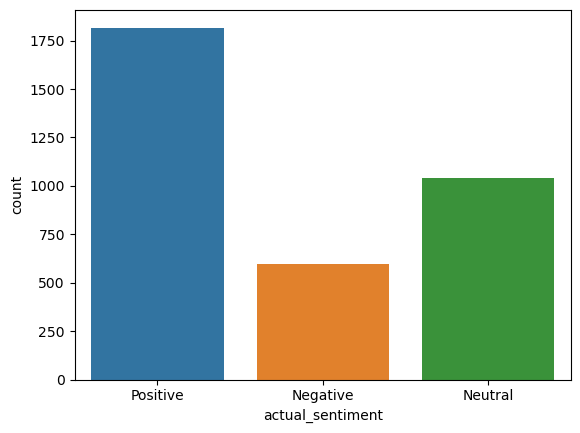

In [57]:
sns.countplot(data=train, x="actual_sentiment")

In [58]:
fig = go.Figure(go.Funnelarea(
    text =temp["actual_sentiment"],
    values = temp["translated_review"],
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

### Word Cloud

In [59]:
texts = ''
for text in train["translated_review"]:
  texts += ' ' + text

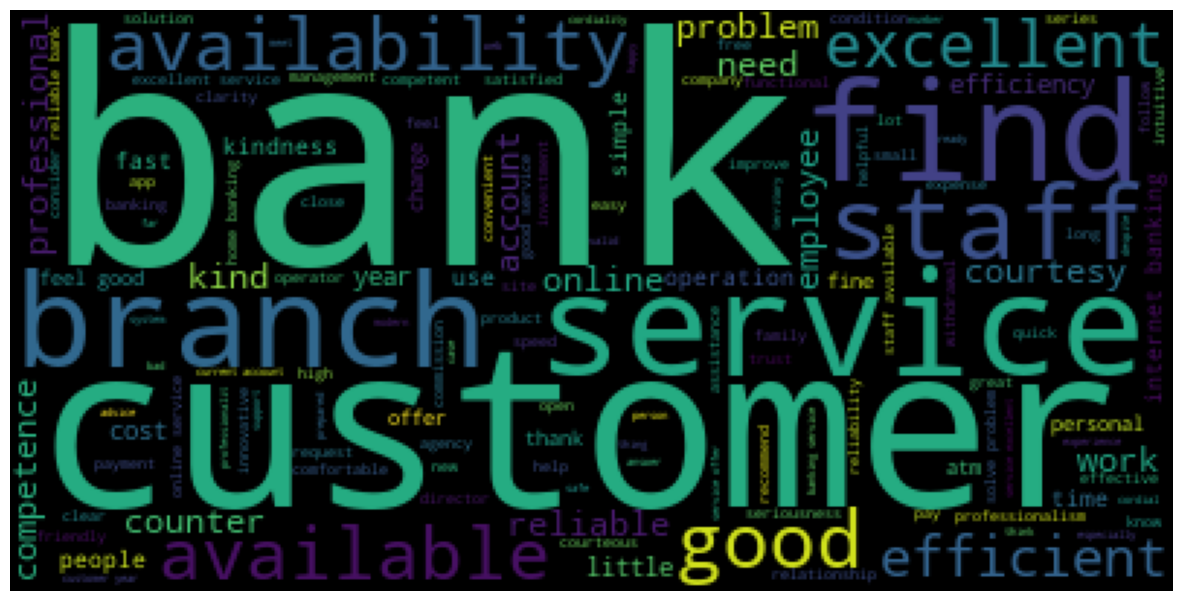

In [60]:
cloud = WordCloud()
cloud = cloud.generate(texts)
plt.figure(figsize=(15,15))
plt.imshow(cloud)
plt.axis('off');

### Words per review

In [61]:
train['words_per_review_after_processing'] = [len(x.split()) for x in train['translated_review'].tolist()]
train.head()

review_id                                  translated_review  \
0          1  branch san marco evangelista employee include ...   
1          2       5 00 commission withdraw money counter theft   
2          3                                      f24 app thank   
3          4                                   lower commission   
4          5           promote support small business territory   

  actual_sentiment  words_per_review  words_per_review_after_processing  
0         Positive                28                                 13  
1         Negative                13                                  7  
2          Neutral                 7                                  3  
3          Neutral                 3                                  2  
4         Positive                 9                                  5

<Axes: xlabel='words_per_review_after_processing', ylabel='count'>

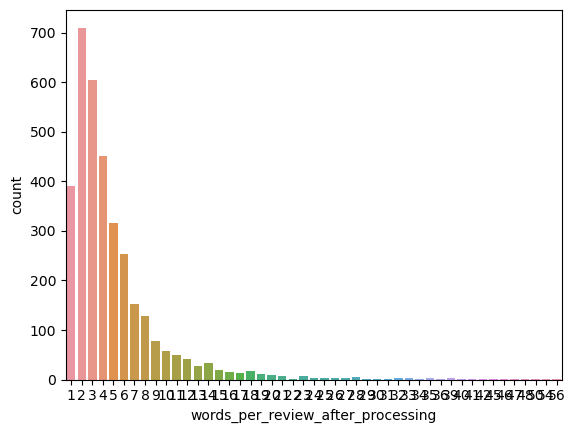

In [62]:
sns.countplot(data=train, x="words_per_review_after_processing")

In [63]:
test['words_per_review_after_processing'] = [len(x.split()) for x in test['translated_review'].tolist()]
test.head()

review_id                                  translated_review  \
0         41                                       c little fix   
1         44  multiple area improvement example mutual field...   
2         76               banca xxyyzz valdengo great director   
3        111               banca xxyyzz valdengo great director   
4        131  lower vote previous evaluation impact find gra...   

  actual_sentiment  words_per_review  words_per_review_after_processing  
0          Neutral                 6                                  3  
1          Neutral                11                                  8  
2         Positive                 8                                  5  
3         Negative                 8                                  5  
4         Negative                36                                 17

<Axes: xlabel='words_per_review_after_processing', ylabel='count'>

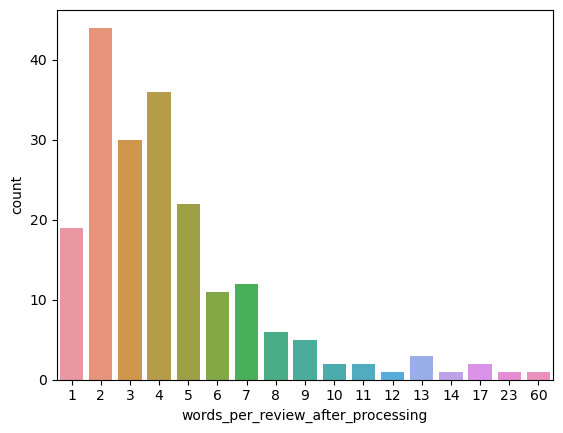

In [64]:
sns.countplot(data=test, x="words_per_review_after_processing")

We can see maximum reviews have very less words. Most of the reviews have 2 words only

### Word count difference after processing

In [65]:
train["word_count_diff"] = train['words_per_review'] - train['words_per_review_after_processing']

In [66]:
train[train["word_count_diff"] > 0]

review_id                                  translated_review  \
0             1  branch san marco evangelista employee include ...   
1             2       5 00 commission withdraw money counter theft   
2             3                                      f24 app thank   
3             4                                   lower commission   
4             5           promote support small business territory   
...         ...                                                ...   
3476       3677                              availability rapidity   
3477       3678                       reliable comfort payment etc   
3478       3679                                               norm   
3479       3680                             poor interest customer   
3480       3681  experience positive customer 2006 2019 close l...   

     actual_sentiment  words_per_review  words_per_review_after_processing  \
0            Positive                28                                 13   
1            Negative                13                                  7   
2             Neutral                 7                                  3   
3             Neutral                 3                                  2   
4            Positive                 9                                  5   
...               ...               ...                                ...   
3476          Neutral                 3                                  2   
3477          Neutral                 6                                  4   
3478          Neutral                 4                                  1   
3479         Negative                 4                                  3   
3480         Negative                20                                  9   

      word_count_diff  
0                  15  
1                   6  
2                   4  
3                   1  
4                   4  
...               ...  
3476                1  
3477                2  
3478                3  
3479                1  
3480               11  

[3020 rows x 6 columns]

So, there are 3020 reviews out of 3454 reviews where words have been removed as part of the data processing

In [67]:
test["word_count_diff"] = test['words_per_review'] - test['words_per_review_after_processing']

In [68]:
test[test["word_count_diff"] > 0]

review_id                                  translated_review  \
0           41                                       c little fix   
1           44  multiple area improvement example mutual field...   
2           76               banca xxyyzz valdengo great director   
3          111               banca xxyyzz valdengo great director   
4          131  lower vote previous evaluation impact find gra...   
..         ...                                                ...   
195       3583                   excellent bank excellent service   
196       3607                                      staff helpful   
197       3625              excellent service kindness competence   
198       3644               excellent service excellent courtesy   
199       3675                                               fast   

    actual_sentiment  words_per_review  words_per_review_after_processing  \
0            Neutral                 6                                  3   
1            Neutral                11                                  8   
2           Positive                 8                                  5   
3           Negative                 8                                  5   
4           Negative                36                                 17   
..               ...               ...                                ...   
195         Positive                 5                                  4   
196         Positive                 5                                  2   
197         Positive                 5                                  4   
198         Positive                 8                                  4   
199         Negative                 2                                  1   

     word_count_diff  
0                  3  
1                  3  
2                  3  
3                  3  
4                 19  
..               ...  
195                1  
196                3  
197                1  
198                4  
199                1  

[173 rows x 6 columns]

In test data also there are 173 reviews out of 198 reviews where words have been removed as part of the data processing

In [69]:
print(train_raw_data.shape, train.shape)

(3477, 3) (3454, 6)


after processing (3477-3454 =) 23 reviews have been removed as they don't have any values left in reviews.

In [70]:
train[["review_id", "translated_review", "actual_sentiment"]].to_excel("data/train_data.xlsx", index=False)

In [71]:
train = train[["review_id", "translated_review", "actual_sentiment"]]

In [72]:
test = test[["review_id", "translated_review", "actual_sentiment"]]

## Modeling

### Split data

In [73]:
# split into inputs and outputs
X, y = train["translated_review"].values, train["actual_sentiment"].values
print(X.shape, y.shape)
# split into train test sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42, shuffle=True)

(3454,) (3454,)


In [74]:
print(X_train.shape, X_valid.shape)

(3108,) (346,)


In [75]:
X_test, y_test = test["translated_review"].values, test["actual_sentiment"].values

### Building vectors

#### TF-IDF Vectorizer

In [76]:
# tfidf_vectorizer = feature_extraction.text.TfidfVectorizer()
tfidf_vectorizer = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

In [77]:
tfidf_vectorizer.fit(list(X_train) + list(X_valid))

/home/saikat/miniconda3/envs/nlp/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:558: FutureWarning:

Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.



TfidfVectorizer(min_df=3, ngram_range=(1, 3), smooth_idf=1,
                stop_words='english', strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [78]:
tfidf_xtrain_vectors =  tfidf_vectorizer.transform(X_train) 
tfidf_xvalid_vectors = tfidf_vectorizer.transform(X_valid)
tfidf_xtest_vectors = tfidf_vectorizer.transform(X_test)

In [79]:
print(tfidf_xtrain_vectors.shape, tfidf_xvalid_vectors.shape, tfidf_xtest_vectors.shape)

(3108, 1407) (346, 1407) (198, 1407)


#### Count Vectorizer

In [80]:
ct_vectorizer = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

In [81]:
# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ct_vectorizer.fit(list(X_train) + list(X_valid))

CountVectorizer(ngram_range=(1, 3), stop_words='english',
                token_pattern='\\w{1,}')

In [82]:
ct_xtrain_vectors =  ct_vectorizer.transform(X_train) 
ct_xvalid_vectors = ct_vectorizer.transform(X_valid)
ct_xtest_vectors = ct_vectorizer.transform(X_test)

In [83]:
print(ct_xtrain_vectors.shape, ct_xvalid_vectors.shape, ct_xtest_vectors.shape)

(3108, 23248) (346, 23248) (198, 23248)


### Logistic Regression

#### On TF-IDF vectorized data

In [84]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0)
clf.fit(tfidf_xtrain_vectors, y_train)

LogisticRegression()

In [85]:
predictions = clf.predict(tfidf_xvalid_vectors)

In [86]:
accuracy_score(y_valid, predictions)

0.630057803468208

On unseen data

In [87]:
predictions_unseen = clf.predict(tfidf_xtest_vectors)

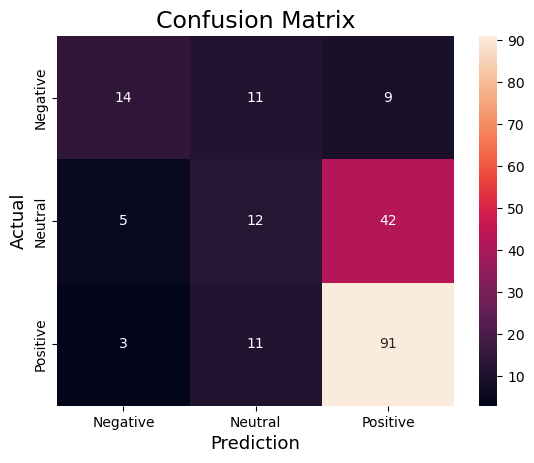

In [88]:
#compute the confusion matrix.
cm = confusion_matrix(y_test, predictions_unseen)

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=["Negative","Neutral", "Positive"],
            yticklabels=["Negative","Neutral", "Positive"]
            )
plt.ylabel("Actual", fontsize=13)
plt.xlabel("Prediction", fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [89]:
print("Accuracy Score:", accuracy_score(y_test, predictions_unseen))

Accuracy Score: 0.5909090909090909


In [90]:
print(classification_report(y_test, predictions_unseen))

              precision    recall  f1-score   support

    Negative       0.64      0.41      0.50        34
     Neutral       0.35      0.20      0.26        59
    Positive       0.64      0.87      0.74       105

    accuracy                           0.59       198
   macro avg       0.54      0.49      0.50       198
weighted avg       0.55      0.59      0.55       198



#### On Count vectorized data

In [91]:
# Fitting a simple Logistic Regression on Count Vectorized data
logistic_clf = LogisticRegression(C=1.0)
logistic_clf.fit(ct_xtrain_vectors, y_train)

LogisticRegression()

In [92]:
predictions = logistic_clf.predict(ct_xvalid_vectors)

In [93]:
accuracy_score(y_valid, predictions)

0.5924855491329479

On unseen data

In [94]:
predictions_unseen = logistic_clf.predict(ct_xtest_vectors)

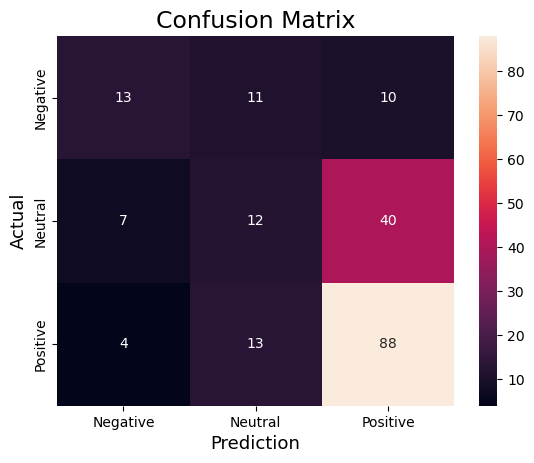

In [95]:
#compute the confusion matrix.
cm = confusion_matrix(y_test, predictions_unseen)

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=["Negative","Neutral", "Positive"],
            yticklabels=["Negative","Neutral", "Positive"]
            )
plt.ylabel("Actual", fontsize=13)
plt.xlabel("Prediction", fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [96]:
print("Accuracy Score:", accuracy_score(y_test, predictions_unseen))

Accuracy Score: 0.5707070707070707


In [97]:
print(classification_report(y_test, predictions_unseen))

              precision    recall  f1-score   support

    Negative       0.54      0.38      0.45        34
     Neutral       0.33      0.20      0.25        59
    Positive       0.64      0.84      0.72       105

    accuracy                           0.57       198
   macro avg       0.50      0.47      0.48       198
weighted avg       0.53      0.57      0.54       198



Count vectorization is giving less accuracy than TF-IDF vectorization

### Ridge Classifier

#### On TF-IDF vectorized data

In [98]:
ridge_clf = RidgeClassifier()

In [99]:
ridge_clf.fit(tfidf_xtrain_vectors, y_train)

RidgeClassifier()

In [100]:
predictions = ridge_clf.predict(tfidf_xvalid_vectors)

In [101]:
accuracy_score(y_valid, predictions)

0.615606936416185

On unseen data

In [102]:
predictions_unseen = ridge_clf.predict(tfidf_xtest_vectors)

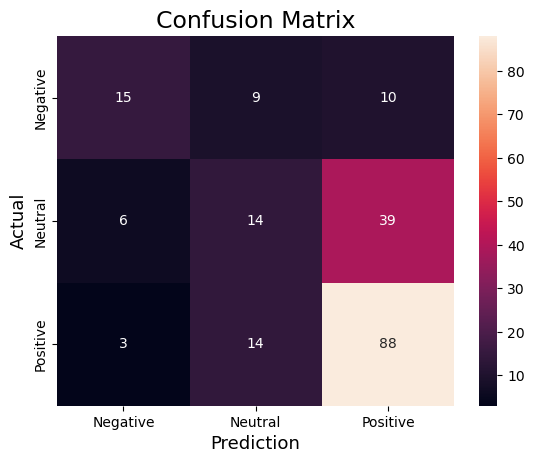

In [103]:
#compute the confusion matrix.
cm = confusion_matrix(y_test, predictions_unseen)

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=["Negative","Neutral", "Positive"],
            yticklabels=["Negative","Neutral", "Positive"]
            )
plt.ylabel("Actual", fontsize=13)
plt.xlabel("Prediction", fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [104]:
print("Accuracy Score:", accuracy_score(y_test, predictions_unseen))

Accuracy Score: 0.5909090909090909


In [105]:
print(classification_report(y_test, predictions_unseen))

              precision    recall  f1-score   support

    Negative       0.62      0.44      0.52        34
     Neutral       0.38      0.24      0.29        59
    Positive       0.64      0.84      0.73       105

    accuracy                           0.59       198
   macro avg       0.55      0.51      0.51       198
weighted avg       0.56      0.59      0.56       198



#### On Count vectorized data

In [106]:
ridge_clf.fit(ct_xtrain_vectors, y_train)

RidgeClassifier()

In [107]:
predictions = ridge_clf.predict(ct_xvalid_vectors)

In [108]:
accuracy_score(y_valid, predictions)

0.5924855491329479

On unseen data

In [109]:
predictions_unseen = ridge_clf.predict(ct_xtest_vectors)

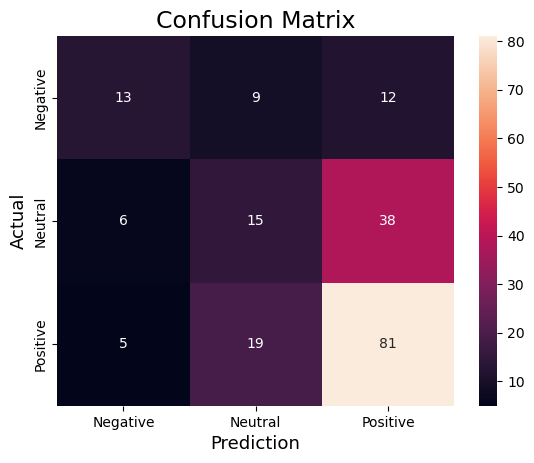

In [110]:
#compute the confusion matrix.
cm = confusion_matrix(y_test, predictions_unseen)

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=["Negative","Neutral", "Positive"],
            yticklabels=["Negative","Neutral", "Positive"]
            )
plt.ylabel("Actual", fontsize=13)
plt.xlabel("Prediction", fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [111]:
print("Accuracy Score:", accuracy_score(y_test, predictions_unseen))

Accuracy Score: 0.5505050505050505


In [112]:
print(classification_report(y_test, predictions_unseen))

              precision    recall  f1-score   support

    Negative       0.54      0.38      0.45        34
     Neutral       0.35      0.25      0.29        59
    Positive       0.62      0.77      0.69       105

    accuracy                           0.55       198
   macro avg       0.50      0.47      0.48       198
weighted avg       0.52      0.55      0.53       198



Here also TF-IDF vectorized data is working better.

Here for Ridge Classifier accuracy score is almost same as the Logistic Regression

### Decision Tree

#### On TF-IDF vectorized data

In [113]:
dicision_clf = DecisionTreeClassifier()

In [114]:
dicision_clf.fit(tfidf_xtrain_vectors, y_train)

DecisionTreeClassifier()

In [115]:
predictions = dicision_clf.predict(tfidf_xvalid_vectors)

In [116]:
accuracy_score(y_valid, predictions)

0.5722543352601156

On unseen data

In [117]:
predictions_unseen = dicision_clf.predict(tfidf_xtest_vectors)

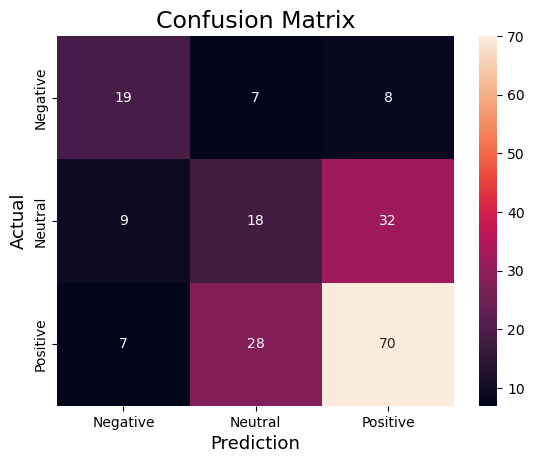

In [118]:
#compute the confusion matrix.
cm = confusion_matrix(y_test, predictions_unseen)

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=["Negative","Neutral", "Positive"],
            yticklabels=["Negative","Neutral", "Positive"]
            )
plt.ylabel("Actual", fontsize=13)
plt.xlabel("Prediction", fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [119]:
print("Accuracy Score:", accuracy_score(y_test, predictions_unseen))

Accuracy Score: 0.5404040404040404


In [120]:
print(classification_report(y_test, predictions_unseen))

              precision    recall  f1-score   support

    Negative       0.54      0.56      0.55        34
     Neutral       0.34      0.31      0.32        59
    Positive       0.64      0.67      0.65       105

    accuracy                           0.54       198
   macro avg       0.51      0.51      0.51       198
weighted avg       0.53      0.54      0.54       198



#### On Count vectorized data

In [121]:
ct_xtrain_vectors

<3108x23248 sparse matrix of type '<class 'numpy.int64'>'
	with 36938 stored elements in Compressed Sparse Row format>

In [122]:
ct_xvalid_vectors

<346x23248 sparse matrix of type '<class 'numpy.int64'>'
	with 4259 stored elements in Compressed Sparse Row format>

In [123]:
dicision_clf.fit(ct_xtrain_vectors, y_train)

DecisionTreeClassifier()

In [124]:
predictions = dicision_clf.predict(ct_xvalid_vectors)

In [125]:
accuracy_score(y_valid, predictions)

0.5260115606936416

On unseen data

In [126]:
predictions_unseen = dicision_clf.predict(ct_xtest_vectors)

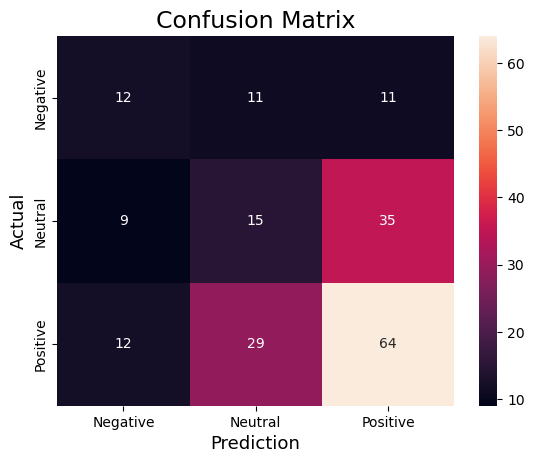

In [127]:
#compute the confusion matrix.
cm = confusion_matrix(y_test, predictions_unseen)

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=["Negative","Neutral", "Positive"],
            yticklabels=["Negative","Neutral", "Positive"]
            )
plt.ylabel("Actual", fontsize=13)
plt.xlabel("Prediction", fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [128]:
print("Accuracy Score:", accuracy_score(y_test, predictions_unseen))

Accuracy Score: 0.4595959595959596


In [129]:
print(classification_report(y_test, predictions_unseen))

              precision    recall  f1-score   support

    Negative       0.36      0.35      0.36        34
     Neutral       0.27      0.25      0.26        59
    Positive       0.58      0.61      0.60       105

    accuracy                           0.46       198
   macro avg       0.41      0.41      0.41       198
weighted avg       0.45      0.46      0.46       198



Decision Tree is giving less accuracy than the other 2 models.

### RoBERTa

We will be using a pre-trained model "cardiffnlp/twitter-roberta-base-sentiment-latest"

In [130]:
MODEL_NAME = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

In [131]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [132]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [133]:
train_reviews = train_raw_data["translated_review"].values
test_reviews = test_raw_data["translated_review"].values

In [134]:
# # using for loop
# labels = ["Negative", "Neutral", "Positive"]
# for text in train_reviews:
#     encoded_input = tokenizer(text, return_tensors='pt')
#     output = model(**encoded_input)
#     scores = output[0][0].detach().numpy()
#     scores = softmax(scores)
#     list_ = []
#     for i in range(len(scores)):

#         l = labels[i]

#         s = scores[i]

#         print(l, s)
#         # list_.append({"label": l, "score": s})
#         list_.append(s)
#     max_ = np.max(list_)
#     print(max_)
#     print("--------------------")

In [135]:
# using pipeline
from transformers import pipeline
sentiment_task = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [136]:
predicted_output = sentiment_task(list(test_reviews))

In [137]:
predicted_output

[{'label': 'negative', 'score': 0.5028409957885742},
 {'label': 'neutral', 'score': 0.49264416098594666},
 {'label': 'positive', 'score': 0.910467803478241},
 {'label': 'positive', 'score': 0.910467803478241},
 {'label': 'negative', 'score': 0.7401549816131592},
 {'label': 'negative', 'score': 0.47808465361595154},
 {'label': 'negative', 'score': 0.7956034541130066},
 {'label': 'positive', 'score': 0.6167091131210327},
 {'label': 'neutral', 'score': 0.7869182825088501},
 {'label': 'neutral', 'score': 0.44397738575935364},
 {'label': 'positive', 'score': 0.5892969965934753},
 {'label': 'neutral', 'score': 0.704685628414154},
 {'label': 'positive', 'score': 0.8517541289329529},
 {'label': 'neutral', 'score': 0.617101788520813},
 {'label': 'negative', 'score': 0.5735548734664917},
 {'label': 'neutral', 'score': 0.4942234456539154},
 {'label': 'negative', 'score': 0.7631824612617493},
 {'label': 'neutral', 'score': 0.5705015063285828},
 {'label': 'neutral', 'score': 0.5090420842170715},
 {

In [138]:
predictions = [label['label'].capitalize() for label in predicted_output]

In [139]:
accuracy_score(test_raw_data["actual_sentiment"].values, predictions)

0.635

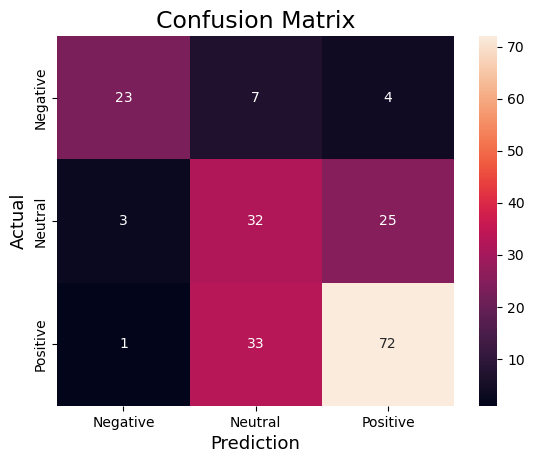

In [140]:
#compute the confusion matrix.
cm = confusion_matrix(test_raw_data["actual_sentiment"].values, predictions)

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=["Negative","Neutral", "Positive"],
            yticklabels=["Negative","Neutral", "Positive"]
            )
plt.ylabel("Actual", fontsize=13)
plt.xlabel("Prediction", fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [141]:
print("Accuracy Score:", accuracy_score(test_raw_data["actual_sentiment"].values, predictions))

Accuracy Score: 0.635


In [142]:
print(classification_report(test_raw_data["actual_sentiment"].values, predictions))

              precision    recall  f1-score   support

    Negative       0.85      0.68      0.75        34
     Neutral       0.44      0.53      0.48        60
    Positive       0.71      0.68      0.70       106

    accuracy                           0.64       200
   macro avg       0.67      0.63      0.64       200
weighted avg       0.66      0.64      0.64       200



It can be seen that this pretrained RoBERTa model is working better than other models.

### TextBlob

In [143]:
# Negative sentiment score
a = TextBlob("I am the worst programmer ever")
a.sentiment

Sentiment(polarity=-1.0, subjectivity=1.0)

In [144]:
def use_textblob(df_translaed_review):
    bloblist_title = list()

    for row in df_translaed_review:
        blob = TextBlob(row)
        bloblist_title.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
        df_review_polarity = pd.DataFrame(bloblist_title, columns = ['sentence','polarity','subjectivity'])
    
    def f_title(df_review_polarity):
        if df_review_polarity['polarity'] > 0:
            val = "Positive"
        elif df_review_polarity['polarity'] == 0:
            val = "Neutral"
        else:
            val = "Negative"
        return val

    df_review_polarity['Sentiment_Type'] = df_review_polarity.apply(f_title, axis=1)
    return df_review_polarity

In [145]:

tb_polarity = use_textblob(test_raw_data["translated_review"])

In [146]:
tb_polarity

sentence  polarity  \
0                             c always a little to fix -0.187500   
1    there are multiple areas of improvement exampl...  0.000000   
2         banca xxyyzz of valdengo to a great director  0.800000   
3         banca xxyyzz of valdengo to a great director  0.800000   
4    i lowered the votes given in previous evaluati... -0.036061   
..                                                 ...       ...   
195              excellent bank and excellent services  1.000000   
196                      the staff always very helpful  0.200000   
197          excellent service kindness and competence  1.000000   
198  as excellent services and also the excellent c...  1.000000   
199                                         quite fast  0.200000   

     subjectivity Sentiment_Type  
0        0.500000       Negative  
1        0.000000        Neutral  
2        0.750000       Positive  
3        0.750000       Positive  
4        0.330909       Negative  
..            ...            ...  
195      1.000000       Positive  
196      0.300000       Positive  
197      1.000000       Positive  
198      1.000000       Positive  
199      0.600000       Positive  

[200 rows x 4 columns]

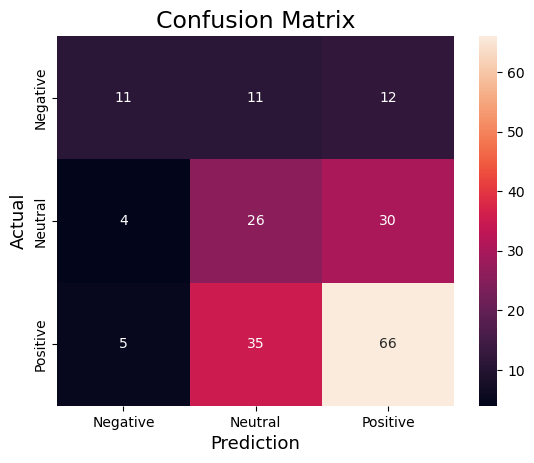

In [147]:
#compute the confusion matrix.
cm = confusion_matrix(test_raw_data["actual_sentiment"], tb_polarity["Sentiment_Type"])

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=["Negative","Neutral", "Positive"],
            yticklabels=["Negative","Neutral", "Positive"]
            )
plt.ylabel("Actual", fontsize=13)
plt.xlabel("Prediction", fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [148]:
print("Accuracy Score:", accuracy_score(test_raw_data["actual_sentiment"], tb_polarity["Sentiment_Type"]))

Accuracy Score: 0.515


In [149]:
print(classification_report(test_raw_data["actual_sentiment"], tb_polarity["Sentiment_Type"]))

              precision    recall  f1-score   support

    Negative       0.55      0.32      0.41        34
     Neutral       0.36      0.43      0.39        60
    Positive       0.61      0.62      0.62       106

    accuracy                           0.52       200
   macro avg       0.51      0.46      0.47       200
weighted avg       0.53      0.52      0.51       200

